We compile smaller AD gene sets, which we will use as a seed gene set for prioritizing a larger number AD candidate genes.  These smallar AD gene sets come from three types of information sources:
1. knowledge bases (from the DISEASES database)
1. TWAS (transcriptome-wide association studies)
1. the incipient AD proteomic signature (Roberts et al unpublished)

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib_venn import venn2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3
import adgenes
import attila_utils

## Preparation

### Correcting gene symbols

Some gene symbols are correct but noncanonical (there's another, more widely used, symbol for the same gene).  Other symbols were mistyped by the authors.  Yet others refer to lincRNAs (long intergenic non-coding RNAs). This was noticed while using the [g:Profiler](https://biit.cs.ut.ee/gprofiler/convert) conversion tool.

To correct this I introduce the following dictionary: (TODO)

In [2]:
alt_symbols = {'GIG25': 'SERPINA3', 'PVRL2': 'NECTIN2', 'RP5-935K16.1': 'ENSG00000270081.1', 'AC012146.1': 'ZNF232-AS1', 'TRAPC6A': 'TRPC6', 'AC135050.3': 'ENSG00000260911', 'CUGBP1': 'CELF1', 'CCNT2-AS1': 'CCNT2-AS1'}

### Transcriptome-wide association studies (TWAS)

First we start with AD gene sets from several TWAS.  See PMIDs below to find each publication.

### [PMID_32299494](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7164172/) Gerring et al 2020

An analysis of genetically regulated gene expression across multiple tissues implicates novel gene candidates in Alzheimer’s disease

In [3]:
PMID_32299494_CMC = pd.read_csv('../../resources/AD-genes/PMID_32299494/Table6.csv')
genesd = {}
df = pd.DataFrame({'Gene': PMID_32299494_CMC['Gene'], 'Author': 'Gerring', 'PMID': 32299494, 'Method': 'S-PrediXcan', 'Tissue': 'cerebral cortex', 'Score': np.log10(PMID_32299494_CMC['P_CMC'])})
genesd['PMID_32299494_CMC'] = adgenes.correct_symbols(df=df, alt_symbols=alt_symbols)

In [4]:
PMID_32299494_FOCUS = pd.read_excel('../../resources/AD-genes/PMID_32299494/13195_2020_611_MOESM6_ESM.xlsx', sheet_name='focus_results')
PMID_32299494_FOCUS = PMID_32299494_FOCUS.loc[PMID_32299494_FOCUS['pip'] > 0.25, :]
PMID_32299494_FOCUS = PMID_32299494_FOCUS.drop(0, 0)
df = pd.DataFrame({'Gene': PMID_32299494_FOCUS['mol_name'], 'Author': 'Gerring', 'PMID': 32299494, 'Method': 'FOCUS', 'Tissue': 'multi tissue', 'Score': np.abs(PMID_32299494_FOCUS['twas_z'])})
#df = pd.DataFrame({'Gene': PMID_32299494_FOCUS['mol_name'], 'Author': 'Gerring', 'PMID': 32299494, 'Method': 'FOCUS', 'Tissue': PMID_32299494_FOCUS['tissue'], 'Score': np.abs(PMID_32299494_FOCUS['twas_z'])})
genesd['PMID_32299494_FOCUS'] = adgenes.correct_symbols(df=df, alt_symbols=alt_symbols)

### [PMID_33417599](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7819609/) Baird et al 2021

Identifying drug targets for neurological and psychiatric disease via genetics and the brain transcriptome

In [5]:
PMID_33417599_MR = pd.read_csv('../../resources/AD-genes/PMID_33417599/journal.pgen.1009224.s005.csv')
PMID_33417599_MR = PMID_33417599_MR.loc[PMID_33417599_MR['outcome (trait)'] == 'AD', ]
df = pd.DataFrame({'Gene': PMID_33417599_MR['exposure (gene)'], 'Author': 'Baird', 'PMID': 33417599, 'Method': 'MR', 'Tissue': 'cerebral cortex', 'Score': np.log10(PMID_33417599_MR['P.2'])})
genesd['PMID_33417599_MR'] = adgenes.correct_symbols(df=df, alt_symbols=alt_symbols)

### [PMID_30617256](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6836675/) Jansen et al 2019

Genome-wide meta-analysis identifies new loci and functional pathways influencing Alzheimer’s disease risk

In [6]:
PMID_30617256 = pd.read_excel('../../resources/AD-genes/PMID_30617256/NIHMS1031924-supplement-Supplemental_Tables.xlsx', sheet_name='Table S19', skiprows=4)
PMID_30617256 = PMID_30617256.loc[~ PMID_30617256.Gene.isna(),]
df = pd.DataFrame({'Gene': PMID_30617256['Gene'], 'Author': 'Jansen', 'PMID': 30617256, 'Method': 'multi method', 'Tissue': 'multi tissue', 'Score': np.log10(PMID_30617256['P'])})
genesd['PMID_30617256'] = adgenes.correct_symbols(df=df, alt_symbols=alt_symbols)

### [PMID_30820047](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6463297/) Kunkle et al 2019

Genetic meta-analysis of diagnosed Alzheimer’s disease identifies new risk loci and implicates Aβ, tau, immunity and lipid processing

In [7]:
PMID_30820047_MR = pd.read_excel('../../resources/AD-genes/PMID_30820047/NIHMS1021255-supplement-S3.xlsx', sheet_name='Supplementary Table 15', skiprows=2)
PMID_30820047_MR = PMID_30820047_MR.loc[~ PMID_30820047_MR['PSMR FDR'].isna(),]
PMID_30820047_MR = PMID_30820047_MR.groupby('Gene').first()
df = pd.DataFrame({'Gene': PMID_30820047_MR.index, 'Author': 'Kunkle', 'PMID': 30820047, 'Method': 'SMR-HEIDI', 'Tissue': 'blood', 'Score': np.log10(PMID_30820047_MR['P SRM'])})
genesd['PMID_30820047_MR'] = adgenes.correct_symbols(df=df, alt_symbols=alt_symbols)

In [8]:
PMID_30820047_COLOC = pd.read_excel('../../resources/AD-genes/PMID_30820047/NIHMS1021255-supplement-S3.xlsx', sheet_name='Supplementary Table 14', skiprows=3)
PMID_30820047_COLOC = PMID_30820047_COLOC.drop(df.columns[12:], axis=1)
PMID_30820047_COLOC = PMID_30820047_COLOC.loc[PMID_30820047_COLOC['GTEx Tissue Class'].isin({'Brain', 'Blood'}), :]
PMID_30820047_COLOC = PMID_30820047_COLOC.groupby('Locus').first()
df = pd.DataFrame({'Gene': PMID_30820047_COLOC['eQTL Gene Name'], 'Author': 'Kunkle', 'PMID': 30820047, 'Method': 'COLOC', 'Tissue': 'brain or blood', 'Score': PMID_30820047_COLOC['PP.H4.abf']})
genesd['PMID_30820047_COLOC'] = adgenes.correct_symbols(df=df, alt_symbols=alt_symbols)

### [PMID_33510477](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8130821/) Wingo et al 2021

Integrating human brain proteomes with genome-wide association data implicates new proteins in Alzheimer’s disease pathogenesis

In [9]:
PMID_33510477 = pd.read_excel('../../resources/AD-genes/PMID_33510477/NIHMS1656683-supplement-2.xlsx', sheet_name='SupTb2', skiprows=2)
PMID_33510477 = PMID_33510477.loc[PMID_33510477['PWAS.P.fdr'] < 0.05, :]
df = pd.DataFrame({'Gene': PMID_33510477['Gene'], 'Author': 'Wingo', 'PMID': 33510477, 'Method': 'SMR-HEIDI & COLOC (PWAS)', 'Tissue': 'cerebral cortex', 'Score': np.log10(PMID_33510477['PWAS.P.fdr'])})
genesd['PMID_33510477'] = adgenes.correct_symbols(df=df, alt_symbols=alt_symbols)

In [10]:
genes = pd.concat(genesd.values())
genes['Analysis'] = genes.apply(lambda x: x.Author + ', ' + x.Method + ', ' + x.Tissue, axis=1)

### DISEASES

In [11]:
cols = ['Ensemble ID', 'Gene', 'DOID', 'Disease', 'Source', 'Type', 'Confidence']
diseases = pd.read_csv('../../resources/DISEASES/human_disease_knowledge_filtered.tsv', sep='\t', names=cols)
diseases = diseases.loc[diseases.Disease == "Alzheimer's disease", ]
diseases = adgenes.correct_symbols(df=diseases, alt_symbols=alt_symbols)
diseases

,Ensemble ID,Gene,DOID,Disease,Source,Type,Confidence
8,ENSP00000012443,PPP5C,DOID:10652,Alzheimer's disease,UniProtKB-KW,CURATED,4
277,ENSP00000222330,GSK3A,DOID:10652,Alzheimer's disease,UniProtKB-KW,CURATED,4
504,ENSP00000236671,CTSD,DOID:10652,Alzheimer's disease,AmyCo,CURATED,4
505,ENSP00000236671,CTSD,DOID:10652,Alzheimer's disease,UniProtKB-KW,CURATED,4
770,ENSP00000252486,APOE,DOID:10652,Alzheimer's disease,AmyCo,CURATED,4
771,ENSP00000252486,APOE,DOID:10652,Alzheimer's disease,GHR,CURATED,5
772,ENSP00000252486,APOE,DOID:10652,Alzheimer's disease,UniProtKB-KW,CURATED,4
866,ENSP00000255040,APCS,DOID:10652,Alzheimer's disease,AmyCo,CURATED,4
1016,ENSP00000260197,SORL1,DOID:10652,Alzheimer's disease,UniProtKB-KW,CURATED,4
1024,ENSP00000260408,ADAM10,DOID:10652,Alzheimer's disease,UniProtKB-KW,CURATED,4


In [12]:
genes_knowledge = set(diseases.Gene)
genes_twas = set(genes.Gene)

### Incipient AD proteomic signature
These are taken from the unpublished manuscript by Jackson Roberts et al: A Brain Proteomic Signature of Incipient Alzheimer’s Disease in Young APOE ε4 Carriers.

In [13]:
genes_proteo = {'AKT2', 'CAMK2B', 'CAMK2D', 'CCL19', 'DAPK2', 'DUSP3', 'FYN', 'GRP', 'HMOX2', 'IFNL2', 'KPNB1', 'LGALS8', 'LRPAP1', 'LRRTM3', 'MAPK12', 'METAP1', 'PDPK1', 'PRKCB', 'PRKCI', 'RNASEH1', 'SNX4', 'STAT3', 'TBP', 'TOP1', 'YES1'}

## Results

### Overlap among AD gene sets

These three AD gene sets are:

1. knowledge based (from DISEASES)
1. union of all sets from all TWAS above
1. Incipient AD proteomic signature

['named-figure/knowledge-twas-proteo-venn.png',
 'named-figure/knowledge-twas-proteo-venn.pdf']

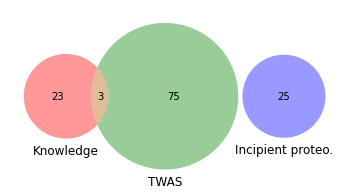

In [14]:
partition = dict()
partition['100'] = genes_knowledge.difference(genes_twas.union(genes_proteo))
partition['010'] = genes_twas.difference(genes_knowledge.union(genes_proteo))
partition['001'] = genes_proteo.difference(genes_twas.union(genes_knowledge))
partition['110'] = genes_knowledge.intersection(genes_twas).difference(genes_proteo)
partition['101'] = genes_knowledge.intersection(genes_proteo).difference(genes_twas)
partition['011'] = genes_twas.intersection(genes_proteo).difference(genes_knowledge)
partition['111'] = genes_knowledge.intersection(genes_twas).intersection(genes_proteo)
subsets = {k: len(v) for k, v in partition.items()}
fig, ax = plt.subplots()
venn3(subsets=subsets, set_labels=('Knowledge', 'TWAS', 'Incipient proteo.'))
attila_utils.savefig(fig, 'knowledge-twas-proteo-venn')

In [15]:
print(sum(subsets.values()), 'genes in total')

126 genes in total


In [16]:
partition['110']

{'ABCA7', 'APOE', 'CLU'}

In [17]:
#A = genes_knowledge.difference(genes_twas)
#B = genes_twas.difference(genes_knowledge)
#AB = genes_twas.intersection(genes_knowledge)
#fig, ax = plt.subplots()
#venn2(subsets = (len(A), len(B), len(AB)), set_labels = ('Knowledge', 'TWAS'), ax=ax)
#attila_utils.savefig(fig, 'knowledge-twas-venn')

### Number of AD genes for each TWAS

In [18]:
print('AD genes discovered by various TWAS:')
{k: len(v) for k, v in genesd.items()}

AD genes discovered by various TWAS:


{'PMID_32299494_CMC': 12,
 'PMID_32299494_FOCUS': 15,
 'PMID_33417599_MR': 15,
 'PMID_30617256': 16,
 'PMID_30820047_MR': 13,
 'PMID_30820047_COLOC': 12,
 'PMID_33510477': 13}

### Number of TWAS discovering each AD gene

['named-figure/no-analyses-inferring-the-same-gene.png',
 'named-figure/no-analyses-inferring-the-same-gene.pdf']

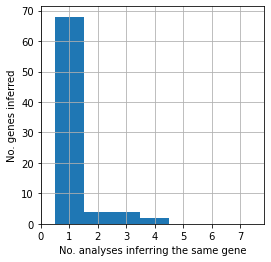

In [19]:
vcounts = genes.Gene.value_counts()
fig, ax = plt.subplots(figsize=(4,4))
analyses = np.arange(len(genesd) + 1)
vcounts.hist(ax=ax, bins=analyses + 0.5)
ax.set_xlabel('No. analyses inferring the same gene')
ax.set_xticks(analyses)
ax.set_ylabel('No. genes inferred')
attila_utils.savefig(fig, 'no-analyses-inferring-the-same-gene')

### Concordance between analyses

In [20]:
all_genes = genes.Gene.sort_values().unique()
def helper(g, n):
    g = g.set_index(g.Gene, drop=False)
    g = g.reindex(all_genes, axis=0)
    g.Analysis = n
    return(g)

df = pd.concat([helper(g, n) for n, g in genes.groupby('Analysis')], axis=0)
df.Gene = df.index
scores = df.pivot(index='Gene', columns='Analysis', values='Score')
scores[~ scores.isna()] = 1
scores = scores.fillna(0)
scores = scores.transpose()

['named-figure/cluster-analyses.png', 'named-figure/cluster-analyses.pdf']

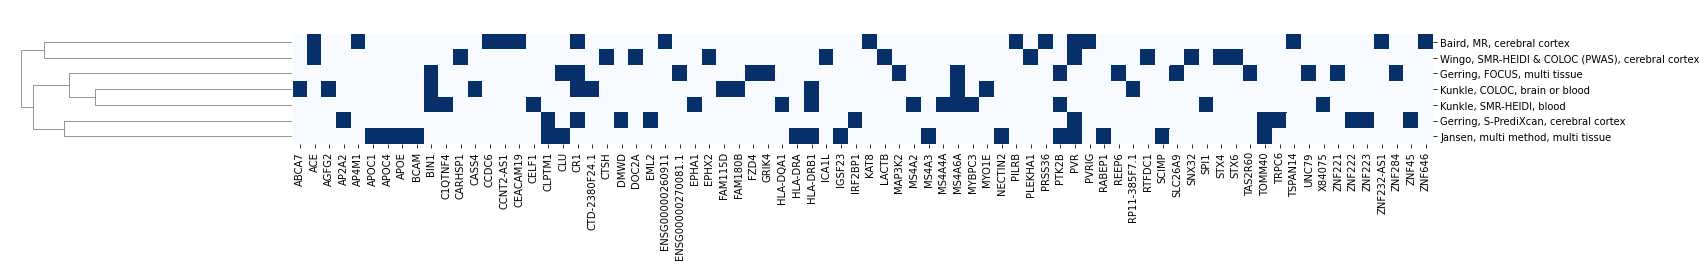

In [21]:
g = sns.clustermap(scores, metric='hamming', col_cluster=False, figsize=(24, 4), cbar_pos=None, cmap=sns.color_palette("Blues", as_cmap=True))
ax = g.fig.axes[2]
ax.set_xlabel('')
ax.set_ylabel('')
attila_utils.savefig(g, 'cluster-analyses')

['named-figure/cluster-analyses-genes.png',
 'named-figure/cluster-analyses-genes.pdf']

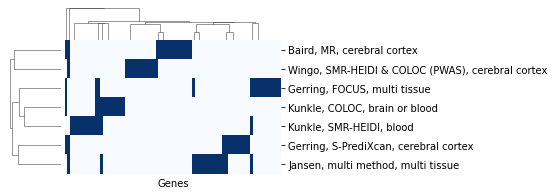

In [22]:
g = sns.clustermap(scores, metric='hamming', col_cluster=True, figsize=(8, 4), cbar_pos=None, cmap=sns.color_palette("Blues", as_cmap=True))
ax = g.fig.axes[2]
labels = ax.set_xticklabels('')
ax.set_xticks([])
ax.set_xlabel('Genes')
ax.set_ylabel('')
attila_utils.savefig(g, 'cluster-analyses-genes')

### Export

In [23]:
def write_geneset(geneset, fpath):
    with open(fpath, 'w') as f:
        for g in geneset:
            print(g, file=f)

write_geneset(genes_knowledge, '../../results/2021-07-01-high-conf-ADgenes/AD-genes-knowledge')
write_geneset(genes_twas, '../../results/2021-07-01-high-conf-ADgenes/AD-genes-twas')
write_geneset(genes_proteo, '../../results/2021-07-01-high-conf-ADgenes/AD-genes-proteo')
genes_seed = genes_knowledge.union(genes_twas).union(genes_proteo)
write_geneset(genes_seed, '../../results/2021-07-01-high-conf-ADgenes/AD-genes-seed')
genes.to_csv('../../results/2021-07-01-high-conf-ADgenes/AD-genes-twas-details.csv', index=False)

### Conversion to Enterz IDs
[This converter](https://biit.cs.ut.ee/gprofiler/convert) was used to get Entrez IDs and gene descriptions.  Some entities (LincRNAs) could not be converted.

In [24]:
%connect_info

{
  "shell_port": 54617,
  "iopub_port": 60977,
  "stdin_port": 60951,
  "control_port": 43025,
  "hb_port": 42649,
  "ip": "127.0.0.1",
  "key": "891c9c62-f6776090cb301a896c85bd4d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-fb1d8178-fd3e-41f6-a16a-9cd6fe682ec3.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
